## Prophet

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))
suppressMessages(library(fable.prophet))

plot_prefix <- 'plots/w12_'

Warning message:
"package 'fable.prophet' was built under R version 4.3.2"


### Prophet
Essentially a nonlinear regression model:

$y_t=g(t)+s(t)+h(t)+\epsilon_t$

- $g(t)$ is a piecewise-linear trend or growth term; this is detected automatically generally.
- $s(t)$ describes various seasonal patterns, which can include daily/weekly seasonality; this is done via Fourier terms.
- $h(t)$ captures holiday effectsl this is done via dummy variables.
- $\epsilon_t$ is the white noise error term

### Comparing ARIMA, ETS, and Prophet on Quarterly Cement Production

In [89]:
cement <- aus_production |>
  filter(year(Quarter) >= 1988)

cement %>% head()

Quarter,Beer,Tobacco,Bricks,Cement,Electricity,Gas
<qtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1988 Q1,474,6034,428,1418,33142,116
1988 Q2,440,7389,519,1625,34664,137
1988 Q3,447,7077,555,1770,37154,157
1988 Q4,598,6837,538,1791,35303,125
1989 Q1,467,6051,510,1621,36905,117
1989 Q2,439,7193,571,1719,37333,149


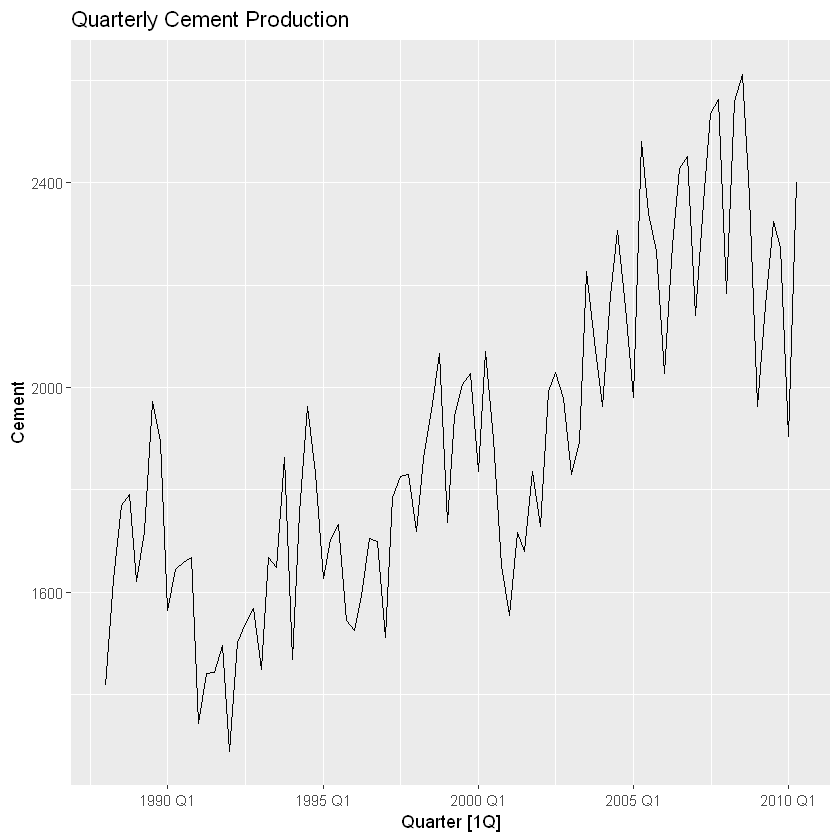

In [90]:
cement %>% autoplot(Cement) + labs(title='Quarterly Cement Production')

ggsave(paste(plot_prefix, 'cement.png', sep=''), height = 3, width=5)

In [91]:
train <- cement |>
  filter(year(Quarter) <= 2007)

fit <- train |>
  model(
    arima = ARIMA(Cement),
    ets = ETS(Cement),
    prophet = prophet(Cement ~ season(period = 4, order = 2, type = "multiplicative")))

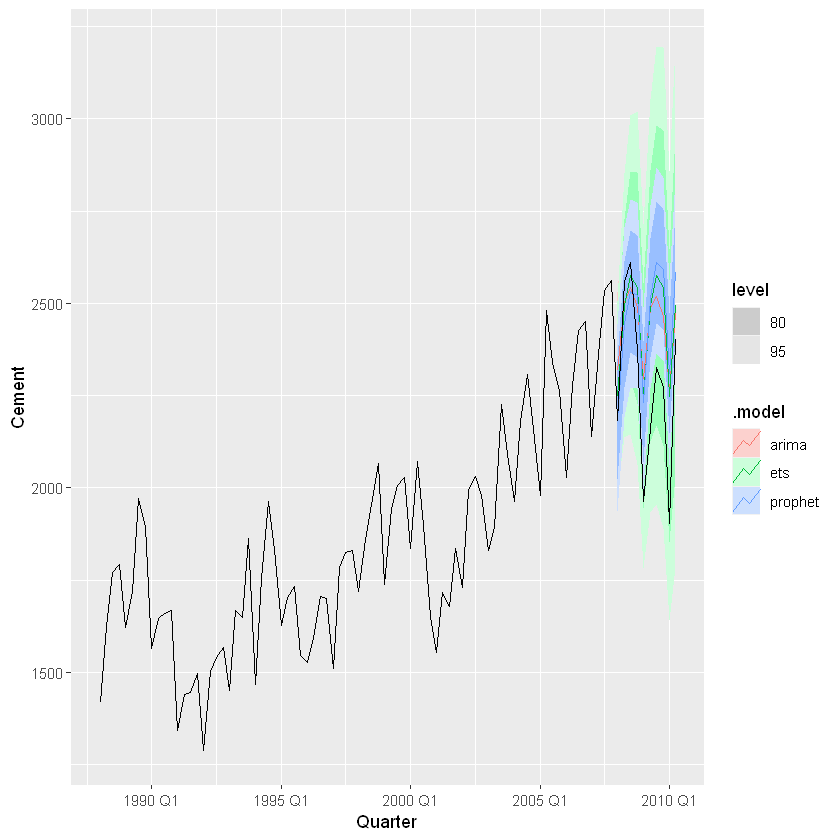

In [92]:
fc <- fit |> forecast(h = "2 years 6 months")
fc |> autoplot(cement)

ggsave(paste(plot_prefix, 'cement_forecasts.png', sep=''), height = 4, width=6)

In [94]:
fc |> accuracy(cement)

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
arima,Test,-160.5363,216.4332,185.5033,-7.711827,8.676720,1.267373,1.258787,0.3870161
ets,Test,-170.8256,222.0420,190.9648,-8.070537,8.852066,1.304686,1.291409,0.5793787
prophet,Test,-176.7839,248.7532,215.6478,-8.394296,9.900495,1.473322,1.446762,0.7034710


In [98]:
fit %>% select(prophet) %>% glance()

.model,sigma,changepoints
<chr>,<dbl>,<list>
prophet,129.9062,"5.916672e+08, 6.073920e+08, 6.311520e+08, 6.467904e+08, 6.704640e+08, 6.862752e+08, 7.099488e+08, 7.258464e+08, 7.494336e+08, 7.651584e+08, 7.889184e+08, 8.045568e+08, 8.283168e+08, 8.441280e+08, 8.677152e+08, 8.836128e+08, 9.072000e+08, 9.229248e+08, 9.466848e+08, 9.624096e+08, 9.860832e+08, 1.001894e+09, 1.025482e+09, 1.041379e+09, 1.064966e+09, 3.029463e-09, 9.317781e-12, -1.331566e-09, 1.149851e-05, 6.357328e-04, 3.837635e-04, 4.898133e-04, 3.983197e-04, 5.145849e-04, 1.032725e-04, 3.983498e-06, 1.662323e-01, 2.301903e-04, 3.597239e-04, 1.628949e-04, 4.590645e-04, 1.491057e-05, 4.401963e-05, 2.760525e-04, 1.797026e-01, 6.009341e-04, 5.881609e-04, 1.022127e-01, 3.121449e-04, 8.340574e-05"


ARIMA is the best performing model. Remember, more complicated does not translate to better modeling, there is a reason why ARIMA and ETS are still heavily used, they are just difficult to beat.

### Prophet Decomposition
Similar to STL, you can see the decomposition of the components.

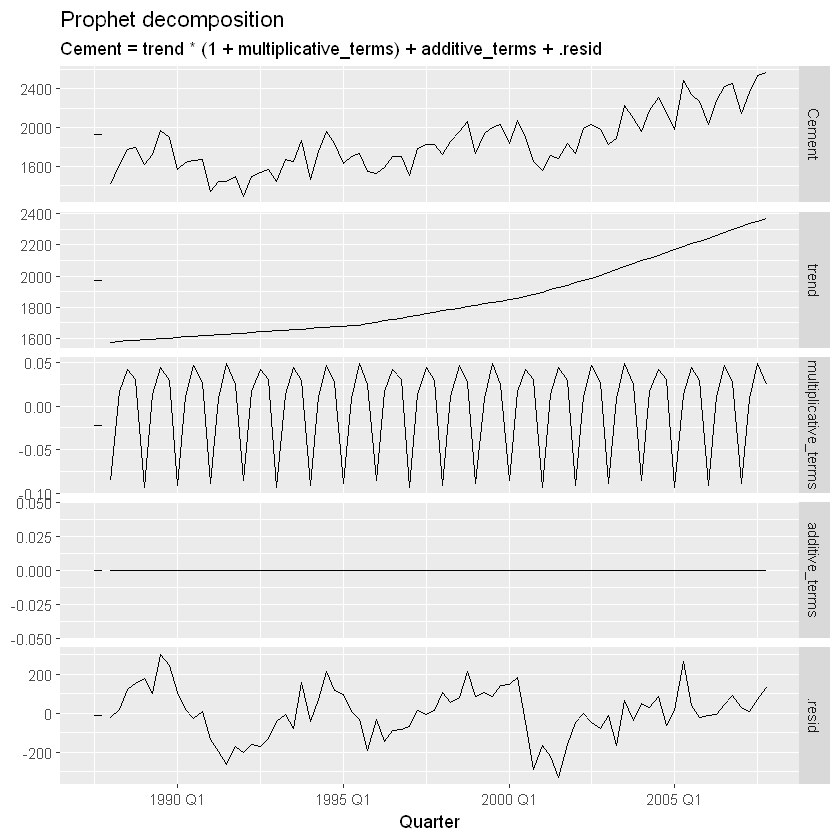

In [7]:
fit %>% select(prophet) %>% components() %>% autoplot()

ggsave(paste(plot_prefix, 'cement_decomp.png', sep=''), height = 6, width=7)

You can see the residuals do not resemble white noise, while the other models have residuals with more desireable characteristics.

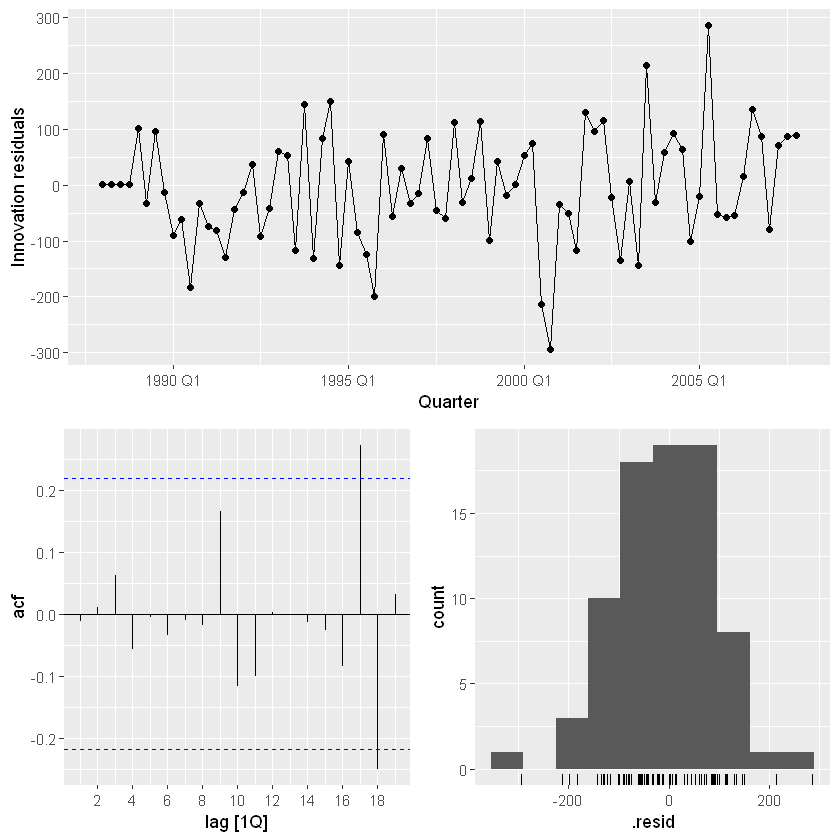

In [8]:
cement_resid_arima <- fit %>% select(arima) %>% gg_tsresiduals()
cement_resid_arima

ggsave(paste(plot_prefix, 'cement_resid_arima.png', sep=''), plot=cement_resid_arima, height = 10, width=6)

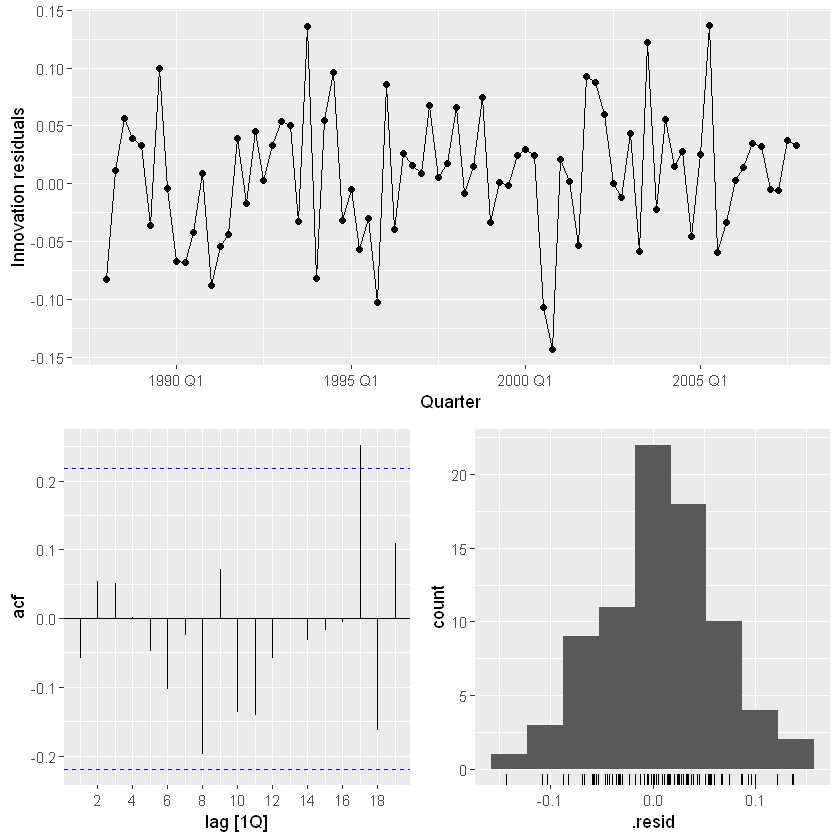

In [9]:
cement_resid_ets <- fit %>% select(ets) %>% gg_tsresiduals()
cement_resid_ets

ggsave(paste(plot_prefix, 'cement_resid_ets.png', sep=''), plot=cement_resid_ets, height = 10, width=6)

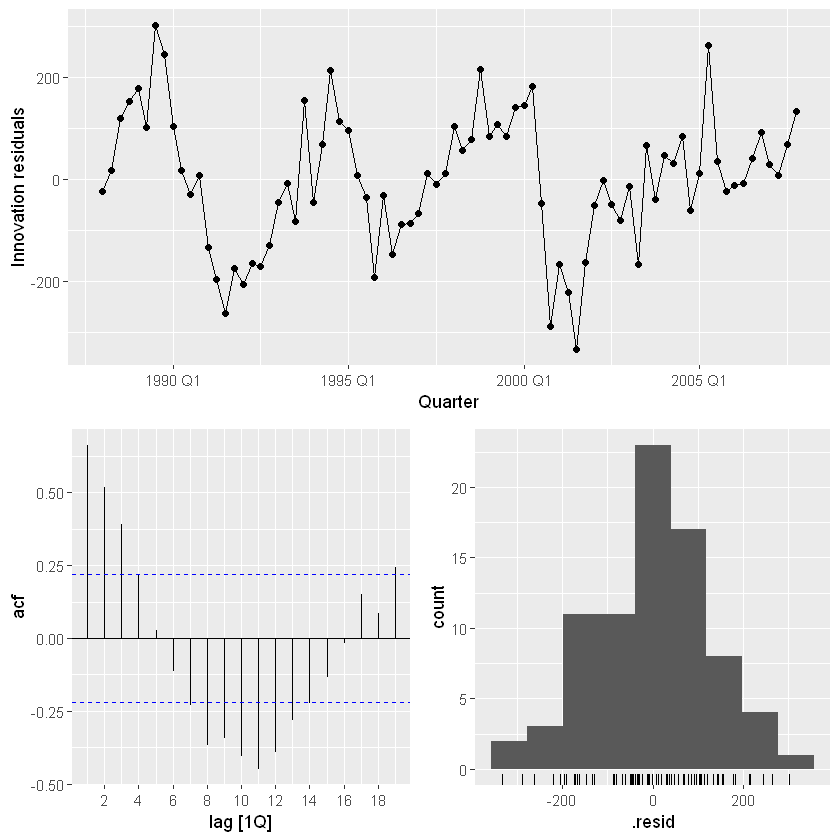

In [10]:
cement_resid_prophet <- fit %>% select(prophet) %>% gg_tsresiduals()
cement_resid_prophet

ggsave(paste(plot_prefix, 'cement_resid_prophet.png', sep=''), plot=cement_resid_prophet, height = 10, width=6)

### Electricity Demand and Prophet
Recall the electricity data has fairly complex seasonality, as it is collected in 30-minute increments.

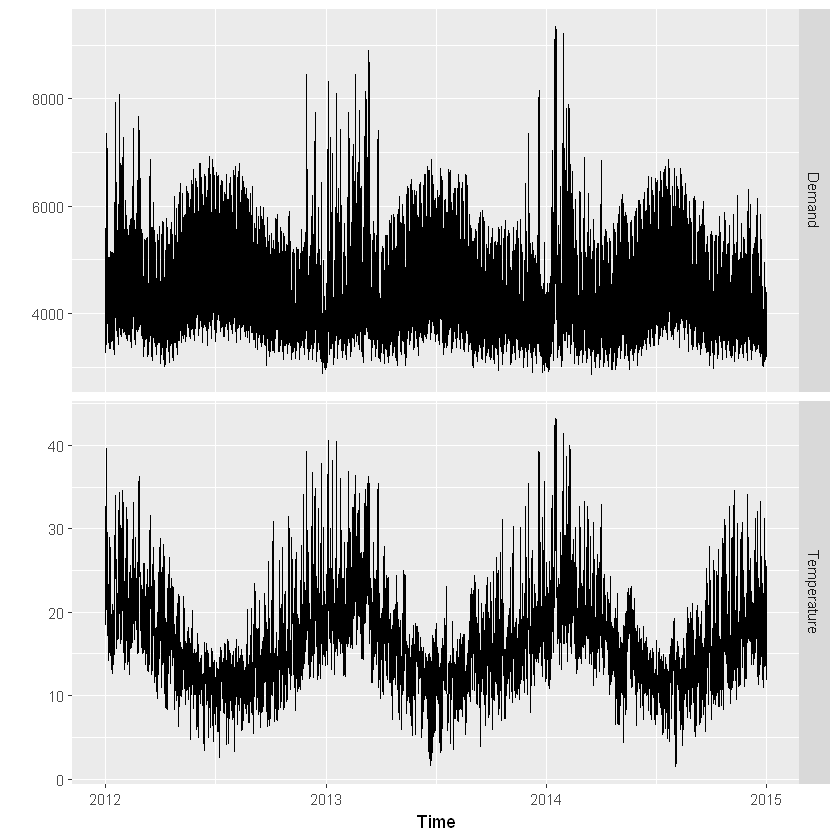

In [11]:
vic_elec |>
  pivot_longer(Demand:Temperature, names_to = "Series") |>
  ggplot(aes(x = Time, y = value)) +
  geom_line() +
  facet_grid(rows = vars(Series), scales = "free_y") +
  labs(y = "")

In [12]:
elec <- vic_elec |>
  mutate(
    DOW = wday(Date, label = TRUE),
    Working_Day = !Holiday & !(DOW %in% c("Sat", "Sun")),
    Cooling = pmax(Temperature, 18)
  )

elec %>% head()

Time,Demand,Temperature,Date,Holiday,DOW,Working_Day,Cooling
<dttm>,<dbl>,<dbl>,<date>,<lgl>,<ord>,<lgl>,<dbl>
2012-01-01 00:00:00,4382.825,21.40,2012-01-01,TRUE,Sun,FALSE,21.40
2012-01-01 00:30:00,4263.366,21.05,2012-01-01,TRUE,Sun,FALSE,21.05
2012-01-01 01:00:00,4048.966,20.70,2012-01-01,TRUE,Sun,FALSE,20.70
2012-01-01 01:30:00,3877.563,20.55,2012-01-01,TRUE,Sun,FALSE,20.55
2012-01-01 02:00:00,4036.230,20.40,2012-01-01,TRUE,Sun,FALSE,20.40
2012-01-01 02:30:00,3865.597,20.25,2012-01-01,TRUE,Sun,FALSE,20.25


Fit a Prophet model, similar to the harmonic regression from the Complex Seasonality slides.

Pros:
- About 10x faster to fit a model.  
- Nearly completely automated.

Cons: 
- The trend component might be projecting a long-term decline that is likely untethered from reality.  
- Residuals still are not white noise.

In [135]:
efit <- elec |>
  model(
    prophet(Demand ~ Temperature + Cooling + Working_Day +
            season(period = "day", order = 10) +
            season(period = "week", order = 5) +
            season(period = "year", order = 3))
  )

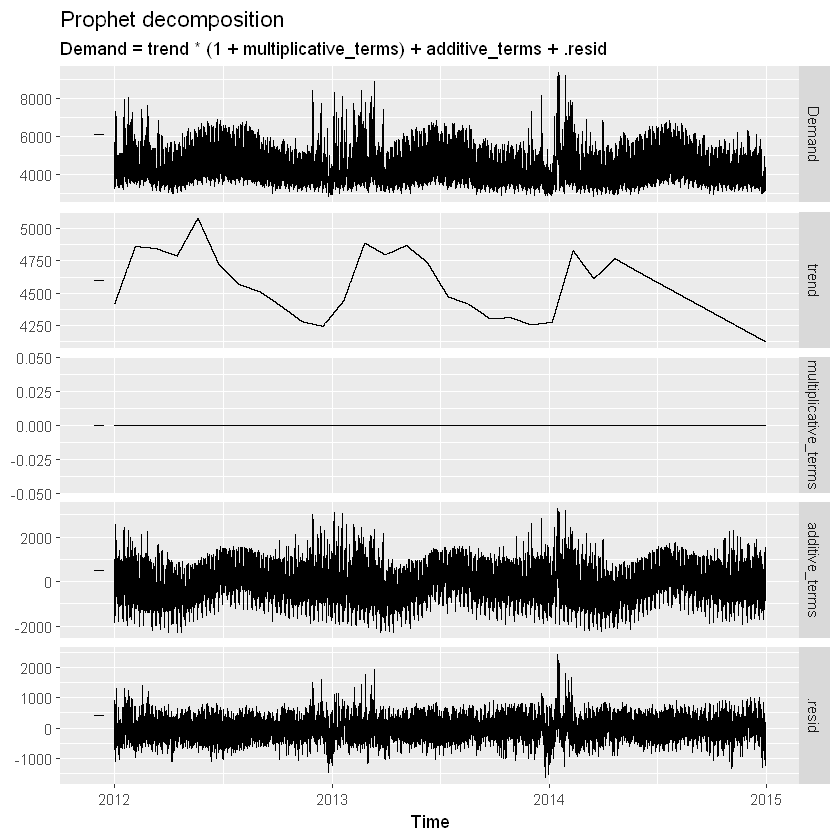

In [136]:
efit |>
  components() |>
  autoplot()

ggsave(paste(plot_prefix, 'elec_demand_prophet_comp_default.png', sep=''), height = 10, width=8)

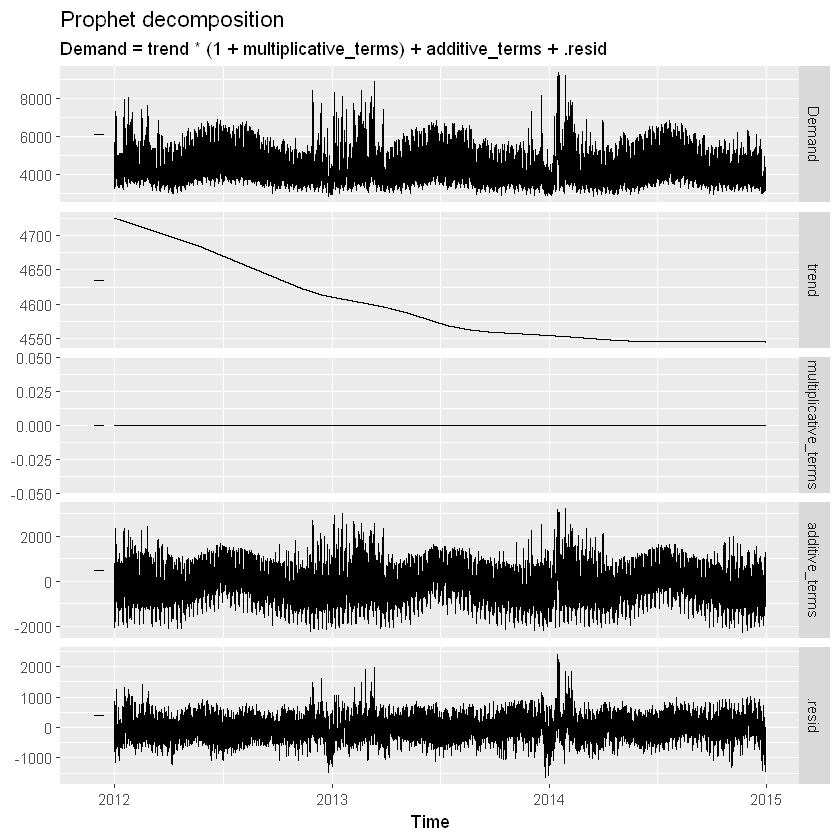

In [137]:
efit <- elec |>
  model(
    prophet(Demand ~ growth(type='logistic', capacity=7000, floor=3000) + Temperature + Cooling + Working_Day +
            season(period = "day", order = 10) +
            season(period = "week", order = 5) +
            season(period = "year", order = 3))
  )

efit |>
  components() |>
  autoplot()

ggsave(paste(plot_prefix, 'elec_demand_prophet_comp.png', sep=''), height = 10, width=8)

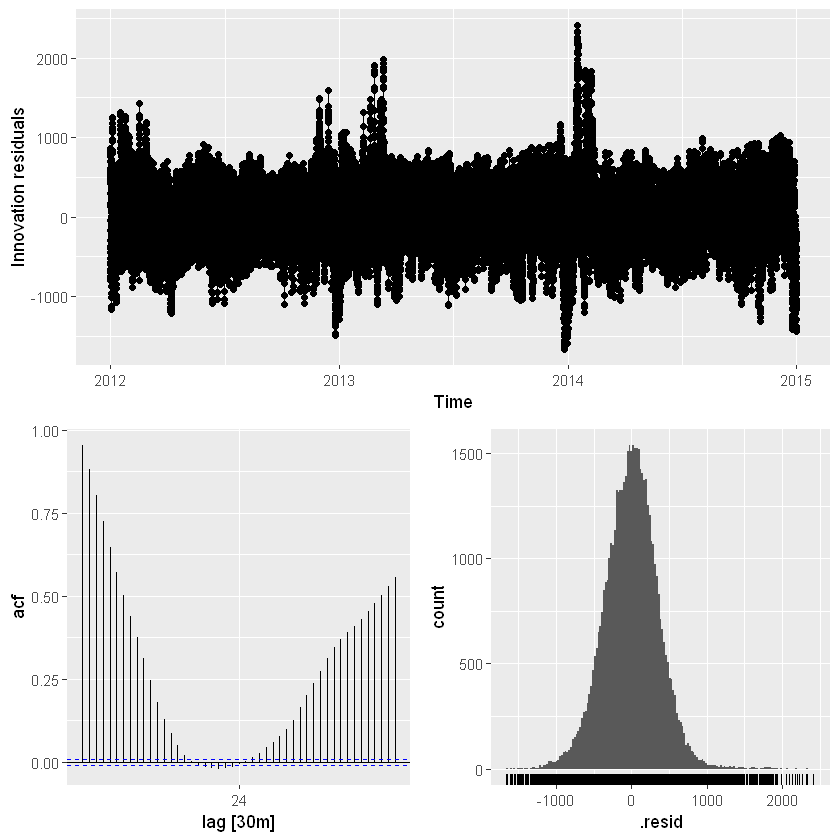

In [142]:
elec_resid_prophet <- efit %>% gg_tsresiduals()
elec_resid_prophet

ggsave(paste(plot_prefix, 'elec_demand_prophet_resid.png', sep=''), plot=elec_resid_prophet, height = 3, width=8)

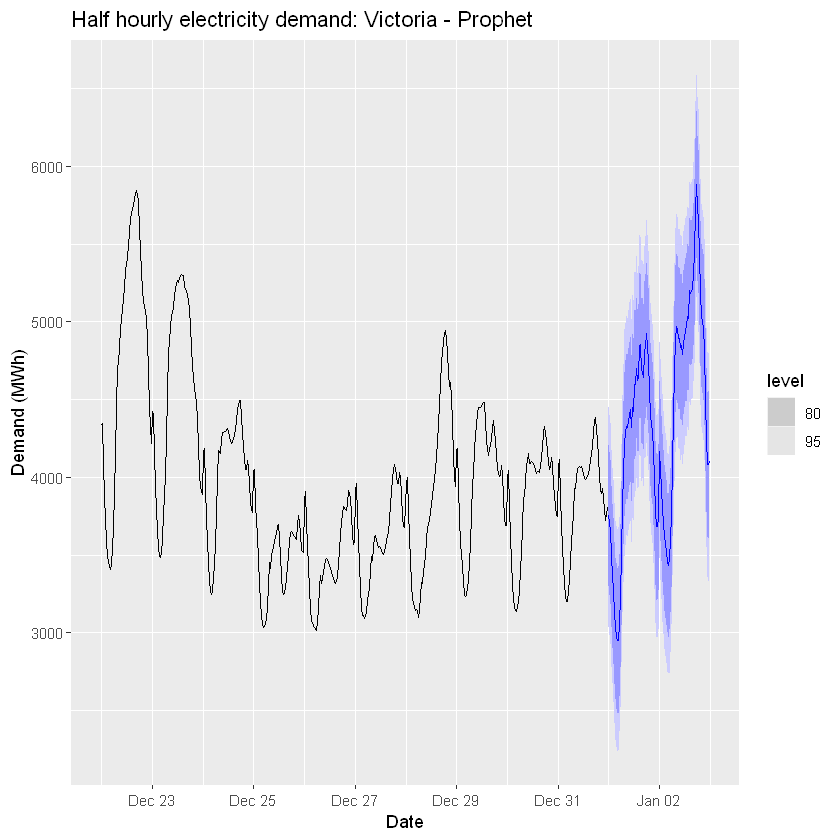

In [139]:
elec_newdata <- new_data(elec, 2*48) |>
  mutate(
    Temperature = tail(elec$Temperature, 2 * 48),
    Date = lubridate::as_date(Time),
    DOW = wday(Date, label = TRUE),
    Working_Day = (Date != "2015-01-01") &
                   !(DOW %in% c("Sat", "Sun")),
    Cooling = pmax(Temperature, 18)
  )

fc <- efit |>
  forecast(new_data = elec_newdata)

fc |>
  autoplot(elec |> tail(10 * 48)) +
  labs(x = "Date", y = "Demand (MWh)", title="Half hourly electricity demand: Victoria - Prophet")

ggsave(paste(plot_prefix, 'elec_demand_prophet_forecasts.png', sep=''),  height = 3, width=6)

Forecasts don't look unreasonable, however, the prediction intervals are unreliable due to the autocorrelations in the residuals.